In [1]:
#!pip install matplotlib

In [2]:
import json
import pprint
import matplotlib.pyplot as plt

from anytree.search import findall
from comorbid_graphs import ComorbidGraph, ComorbidGraphNode

### Creating graph 

In [3]:
with open('../tests/fixtures/symp_tree.json') as f:
    data = json.load(f)
cg = ComorbidGraph(data, ComorbidGraphNode, assign_ids=True)
ne = cg.get_nodes_n_edges()

In [4]:
import networkx as nx
G = nx.Graph()
nodes = [(i['data']['id'], i['data']) for i in ne if 'id' in i['data']]
edges = [(i['data']['source'], i['data']['target']) for i in ne if 'id' not in i['data']]
G.add_nodes_from(nodes)
G.add_edges_from(edges)

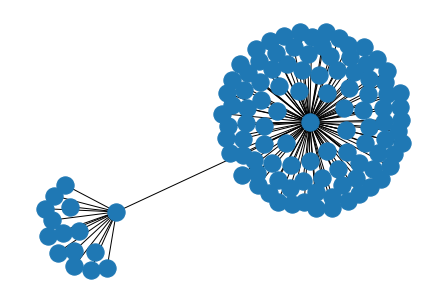

In [5]:
# print(cg.pretty_print_tree())
# ne[0]
#nx.draw(nx.dfs_tree(G))
# nx.dfs_successors(G,"Source 1")
#G[1].degree
nx.draw(G)

## Searching
Searching should be extensible to allow sql search for larger data than KGs.
For this we have a many step search.
- search for ancestors, parents first
  - get the names of these, include-exclude
  - merge all of the nodes, merging with include-exclude
- for docs in the ending KnowledgeGraph
  - filter by type
  - filter by body length
- search in the body

In [6]:
def get_in_name(f, list_words, negate=False):
    return findall(f, filter_=lambda node: any(x in node.name for x in list_words))

search_results = [(x,y) for x,y in G.nodes(data=True) if y['label']=='Source']
search_results

[('Source 1',
  {'id': 'Source 1',
   'label': 'Source',
   'href': '/annotation',
   'type': 'annotation'})]

### 1. Subgraph
Filter the `ancestors` and `parents`, and use `inc-exc` to zoom in.

### 2. Filtering
Filter based on node properties if included or not - `name`, `type`, `body-length`.


### 3. Content
Filter if a certain word or combination of words is found in the document.


## Ordering Results
There should be two options - first the graph properties, second our simple algorithm based on combination of scores - as found in `very-comorbid`.

## Merging all
Create the search language by allowing all entries.   
Control for inputs irregularities and more.

In [7]:
DIRECTION = ['inc_', 'exc_', 'include_', 'exclude_']
FILTERS = ['name', 'phrase', 'type', 'text_longer', 'ancestor', 'parent']

In [8]:
query_str = """
inc_phrase:anxiety
inc_parent:DSM-V
inc_title:Disorder
inc_type:document
inc_text_longer:300
exc_ancestor:Neurodevelopmental Disorders
"""

In [9]:
def clean_query(query_str):
    query_str.replace('  ',' ').replace('\n',' ')
    for i in DIRECTION:
        query_str = query_str.replace(i, '_BREAK_'+ i)
    
    return [
        i.rstrip().lstrip()
        for i in query_str.split('_BREAK_')
        if i.rstrip().lstrip() != ''
    ]
clean_query(query_str)

['inc_phrase:anxiety',
 'inc_parent:DSM-V',
 'inc_title:Disorder',
 'inc_type:document',
 'inc_text_longer:300',
 'exc_ancestor:Neurodevelopmental Disorders']